# Содержание проекта

[1. Описание проекта](#section_1)

[2. Изучение данных из файла](#section_2)

[3. Приоритизация гипотез](#section_3)

[4. Анализ A/B теста](#section_4)

[5. Решение по результатам теста](#section_5)

[6. Выводы](#section_6)

## Описание проекта
<a id='section_1'><a/>

Я аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовил список гипотез для увеличения выручки.
Ниже мы займемся приоритизацией гипотез, запустим A/B-тест и проанализируем результаты.

Проект состоит из двух частей:
- Приоритизация гипотез
- Анализ A/B-теста

### Приоритизация гипотез
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Задача:
- Применить фреймворк ICE для приоритизации гипотез.
- Применить фреймворк RICE для приоритизации гипотез.
- Указать, как изменилась приоритизация гипотез при применении RICE вместо ICE.

### Анализ A/B-теста
В файлах /datasets/orders.csv и /datasets/visitors.csv мы имеем данные поп проведению A/B теста.

Задача:
- Построить график кумулятивной выручки по группам.
- Построить график кумулятивного среднего чека по группам.
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A. 
- Построить график кумулятивной конверсии по группам. 
- Построить график относительного изменения кумулятивной конверсии группы B к группе A.
- Построить точечный график количества заказов по пользователям. 
- Посчитать 95-й и 99-й перцентили количества заказов на пользователя. 
- Построить точечный график стоимостей заказов.
- Посчитать 95-й и 99-й перцентили стоимости заказов. 
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» данным.
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- Посчитать статистическую значимость различий в конверсии между группами по «очищенным» данным. 
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
- Принять решение по результатам теста.

## Изучение данных из файла
<a id='section_2'><a/>

Импортируем библиотеки и считываем данные в переменные.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [10]:
hypothesis = pd.read_csv('hypothesis.csv')
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [11]:
#получим общую информацию и первые пять строк таблиц
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150 
hypothesis.info()
display(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В таблице hypothesis у нас хрянятся сами гипотезы и их характеристики. Необходимо только привести названия столбцов к нижнему регистру.

In [12]:
orders.info()
display(orders.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В таблице orders данные о заказах. Приведем названия столбцов к нижнему регистру, дату к типу данных datetime.

In [13]:
visitors.info()
display(visitors.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


В таблице visitors данные о посещениях в определенные даты. Приведем дату к типу данных datetime.

In [14]:
#приводим назавния столбцов к нижнему регистру и поправим названия при необходимости
hypothesis.columns = hypothesis.columns.str.lower()
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'transactionid':'transaction_id','visitorid':'visitor_id'})
#проверка результатов
display(hypothesis.columns)
display(orders.columns)

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [15]:
#приводим тип данных с датами к типу datetime
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [16]:
#проверим попадание пользователей сразу в обе группы
ab_users = orders.groupby('visitor_id').agg({'group':'nunique'})
ab_users = ab_users.query('group > 1')
ab_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 8300375 to 4266935830
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   group   58 non-null     int64
dtypes: int64(1)
memory usage: 928.0 bytes


### Вывод

- В таблице hypothesis у нас хрянятся сами гипотезы и их характеристики. 
- В таблице orders данные о заказах.
- В таблице visitors данные о посещениях в определенные даты.
- Так же мы имеем 58 пользователей, которые попали в обе группы

## Приоритизация гипотез
<a id='section_3'><a/>

Нам необходимо приоритизировать наши гипотезы по двум фреймворкам ICE и RICE. На основе этих данных мы сможем понять, какие гипотезы нам стоит проверять в первую очередь.

Начнем с приоритизации по ICE.

### Фреймворк ICE

In [17]:
#создаем столбец со значением ICE
hypothesis['ICE'] = round(((
    hypothesis['impact'] *
    hypothesis['confidence']) /
    hypothesis['efforts']
), 1)
#отсортируем данные по новуму столбцу
hypothesis = hypothesis.sort_values(by=['ICE'], ascending = False)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


### Фреймворк RICE

In [18]:
#создаем столбец со значением RICE
hypothesis['RICE'] = ((
    hypothesis['impact'] *
    hypothesis['reach'] *
    hypothesis['confidence']) /
    hypothesis['efforts']
)
#отсортируем данные по новуму столбцу
hypothesis = hypothesis.sort_values(by=['RICE'], ascending = False)
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


### Вывод

- Изначально, по фреймворку ICE, я бы предложил запустить акцию, дающую скидку на товар в день рождения. Но так мы охватим наименьшее количество полльзователей.
- По фреймворку RICE, лучше нам начаться с добавление формы подписки на все основные страницы. Так мы соберем базу клиентов для email-рассылок. 

## Анализ A/B-теста
<a id='section_4'><a/>

### Построение графика кумулятивной выручки по группам

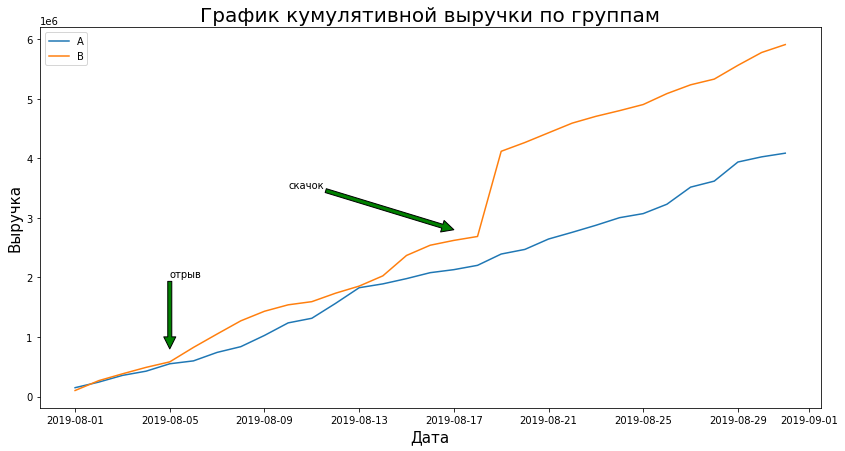

In [19]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]


# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(14,7))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))
plt.title('График кумулятивной выручки по группам', size = 20)
plt.xlabel('Дата', size = 15)
plt.ylabel('Выручка', size = 15)
plt.legend()
plt.show()

Группа В показывала себя сразу лучше, чем группа А. Виден резкий скачок 18 числа и последующий плавный рост. Произошел крупный заказ, который исказил наши данные.

### Построение графика среднего чека по группам

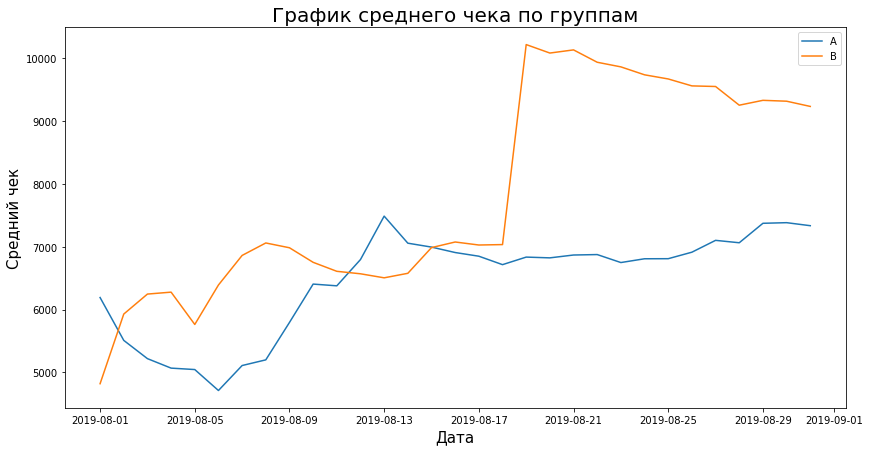

In [20]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

plt.figure(figsize=(14,7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График среднего чека по группам', size = 20)
plt.xlabel('Дата', size = 15)
plt.ylabel('Средний чек', size = 15)
plt.legend()
plt.show()

Тут имеем тоже самое, что и на прошлом графике. Резкий скачок 18го числа. Но средний чек группы В здесь начинает падать, когда чек группы А расти.

### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

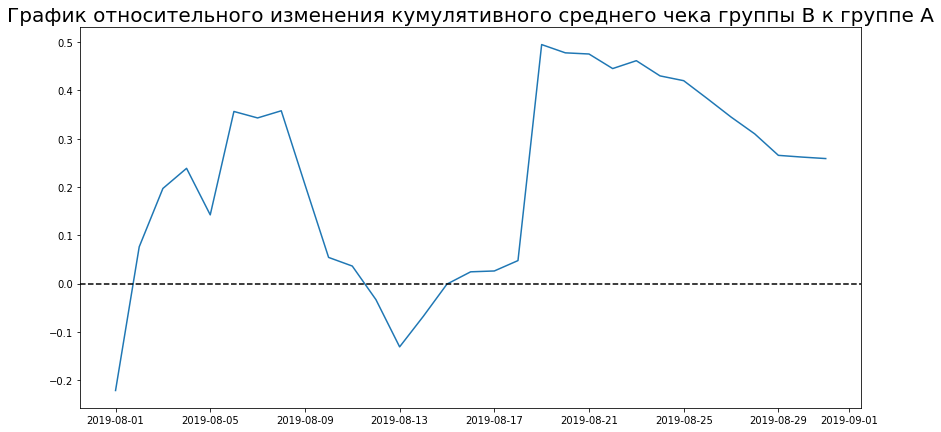

In [21]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14,7))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, label="Относительный прирост среднего чека группы B относительно группы A")

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size = 20)
plt.show()

Видим, что группа В лидирует. Также наш аномальный скачок 18го числа и самый первый день теста.

### Построение графика кумулятивной конверсии по группам

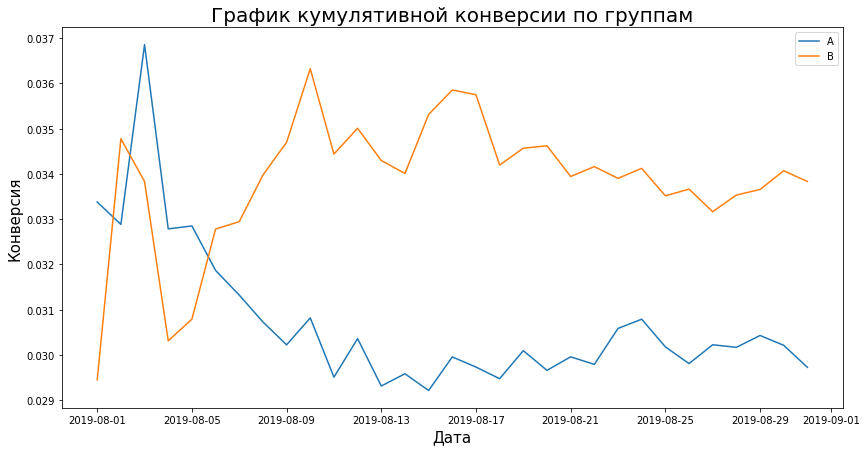

In [22]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(14,7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам', size = 20)
plt.xlabel('Дата', size = 15)
plt.ylabel('Конверсия', size = 15)
plt.legend()
plt.show()

Скачки в начале теста и после конверсия стремится к средним значениям.

### Построение графика относительного изменения кумулятивной конверсии группы B к группе A

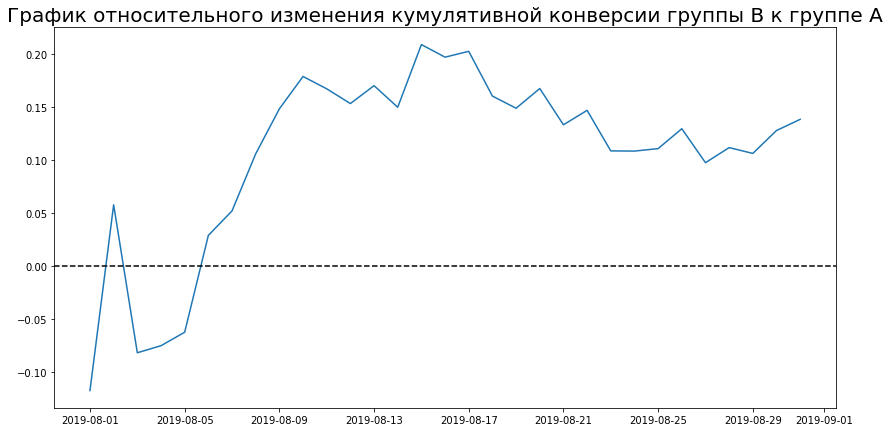

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14,7))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size = 20)
plt.axhline(y=0, color='black', linestyle='--')

plt.show()


Группа В опять показывает себя лучше, чем группа А. Резкие изменения етсь только в нчале теста, но это нормально из-за малого количества данных.

###  Распределение количества заказов

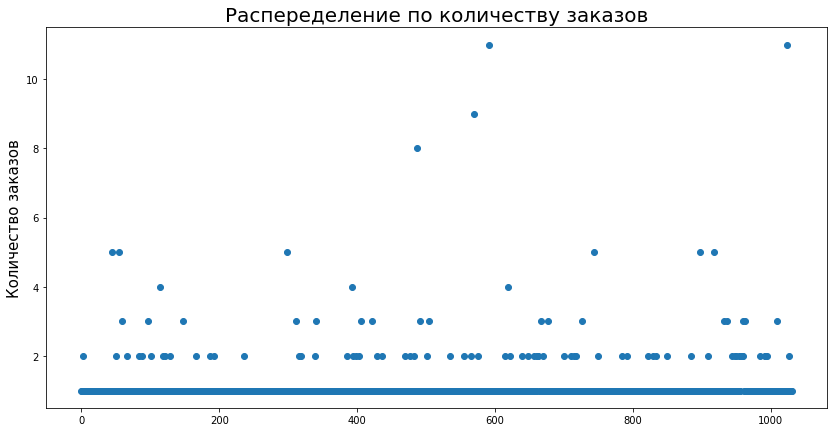

In [24]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsers.columns = ['visitor_id', 'orders']
plt.figure(figsize=(14,7))
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Распеределение по количеству заказов', size = 20)
plt.ylabel('Количество заказов', size = 15)
plt.show()

In [25]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Есть пользователи, которые размещают 11 заказов. 5% делают больше двух заказов. 1% делает больше 4 заказов.

###  Распределение стоимости заказов

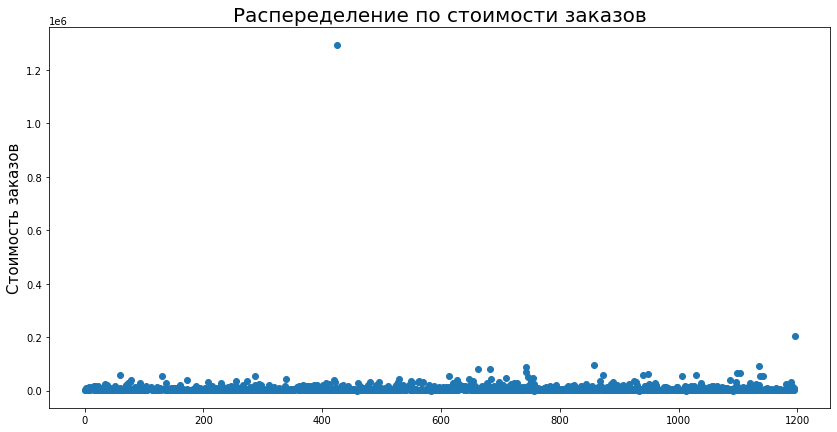

In [26]:
plt.figure(figsize=(14,7))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Распеределение по стоимости заказов', size = 20)
plt.ylabel('Стоимость заказов', size = 15)
plt.show()

In [27]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Есть пользователь, который сделал заказ больше чем на 1,2 млн. Скорее всего аномалия связяна с ним. У 5% пользователей заказы дороже 28000. У 1% пользователей заказы дороже 58233. 

###  Статистическая значимость различий в конверсии между группами по «сырым» данным

Выдвенем две гипотезы:
- H0: данные в выборках взяты из одной и той же генеральной совокупности
- H1: данные в выборках взяты из разных генеральных совокупностей.

In [28]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [29]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [30]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)


,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [31]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 10000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [32]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))

print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

0.01679
0.138


P-value значительно меньше 0.05, потому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы A равен 13.8%.

###  Статистическая значимость различий в среднем чеке между группами по «сырым» данным

In [33]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет. Нулевую гипотезу не отвергаем. Относительное различие среднего чека между сегментами целых 25.9%

###  Чистка данных от аномальных значений

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

###  Статистическая значимость различий в конверсии между группами по «очищенным» данным

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01304
0.173


Как и в случае с сырыми данными, статистическая значимость достигнута. Группа В значительно лучше группы А.

###  Статистическая значимость различий в среднем чеке между группами по «очищенным» данным

In [36]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        alternative = 'two-sided')[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
-0.020


P-value больше 0.05 — статистически значимых отличий в среднем чеке между группами нет

## Решение по результатам теста
<a id='section_5'><a/>

После очистки мы имеем следующие данные:
- Конверсия группы В выше, чем группы А
- Средний чек не отличается.

На основе всего анализа, предлагаю остановить тест и назвать его успешным. Потому что мы можем выделить группу В, как более эффективную по параметру конверсии, что принесет больше денег даже при одинаковом среднем чеке.

Если бы имели одинаковые результаты по конверсиям, важнее нам был бы средний чек. Средний чек у нас одинаковый, поэтому назвали бы мы тест неудачным и остановили. 

## Выводы
<a id='section_6'><a/>

В данном проекте я приоритезировал гипотезы по двум фреймворкам. Мы поняли, что фреймворк RICЕ, больше подходит для работы, т.к. он учитывает охват пользователей. Лучше добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок, чем делать акции на день рождения.

Также проанализировали данные, нашли аномалию в графиках, которая влияла на решение по рузельтатам теста. После очистки данных, сделал вывод, что тест признан успешным и можно его остановить. Группа В показала себя эффективнее в конверсии, чем группа А. Средний чек у групп никак не отличается.

Для предобработки данных я изменил тип данных с столбцах с датами и привел название столбцов в порядок.